##Imports - Downloads

In [1]:
# for reading csv into dataframes
import pandas as pd

# for neural networks, tensors, dataloader (pytorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# for score metrics (precision, recall and f1)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# for data cleaning/preprocessing
import re
import string
import nltk

# download stop words from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# for the learning curves
import matplotlib.pyplot as plt

# for the roc curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# for seeding
torch.manual_seed(0)
import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# download pre-trained word embeddings from GloVe
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-22 18:32:05--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-22 18:32:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 41s  

2021-12-22 18:34:46 (5.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

##Useful functions

In [55]:
# function that performs necessary and useful text cleaning
def data_cleaning(text):
  # lower case text
  text = text.lower()
  # remove unicode characters unreadable in ascii
  text = text.encode('ascii', 'ignore').decode()
  # Remove mentions
  text = re.sub("@\S+", " ", text)
  # Remove URL
  text = re.sub("https*\S+", " ", text)
  # Remove hashtags
  #text = re.sub("#\S+", " ", text)
  # Remove the large spaces/tabs
  text = re.sub('\s{2,}', " ", text)
  # Remove the ' character
  text = re.sub("\'\w+", '', text)
  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  # Remove numbers
  text = re.sub(r'\w*\d+\w*', '', text)
  # Remove stop words
  text = ' '.join([word for word in text.split(' ') if word not in stop_words])
  return text

# function that prints classification scores
def print_scores(y_true, y_pred, train_set):
  if train_set:
    print("Classification scores for training set:\n")
  else:
    print("Classification scores for validation/test set:\n")
  
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  score = f1_score(y_true, y_pred, average='weighted')
  print("Weighted average Precision = ", precision)
  print("Weighted average Recall    = ", recall)
  print("Weighted average F1 score  = ", score)
  print("\n\n")

# make subplot of train epochs in relation to train and validation scores and losses (plot the learning curves)
def make_subplot(epochs, train_scores, validation_scores, title_1, train_losses, validation_losses, title_2):
  # plot learning curves
  print("\n")
  fig = plt.figure(figsize=(16, 6), dpi=120)
  ax1 = fig.add_subplot(1,2,1)
  plt.plot(epochs, train_scores, label="Training Score")
  plt.plot(epochs, validation_scores, label="Validation/Test Score")
  plt.xlabel("Epoch")
  plt.ylabel("Classification F1 Score")
  plt.legend()
  plt.title(title_1)

  ax2 = fig.add_subplot(1,2,2)
  plt.plot(epochs, train_losses, label="Training Loss")
  plt.plot(epochs, validation_losses, label="Validation/Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-Entropy Loss")
  plt.legend()
  plt.title(title_2)

  plt.show()

def plot_roc_curve(y_true, y_pred):

  # Binarize the y_true, y_pred to form one hot vectors of size (size of validation set, #classes)
  y_test = label_binarize(y_true, classes=[0, 1, 2])
  #y_score = label_binarize(y_pred, classes=[0, 1, 2])
  y_score = y_pred
  n_classes = 3

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve
  fig = plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
  
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for all classes')
  plt.legend(loc="lower right")
  plt.show()

# function that converts a list of sentences to a tensor of vectorized sentences
def sentences_to_tensor(sentences, vector_size, word_index_dict, embeddings_array):
  x = np.zeros((len(sentences), vector_size)).astype(np.float)
  index = 0
  for sentence in sentences:
    mean_vector = np.zeros((1, vector_size)).astype(np.float) # mean vector across all words of sentence
    tokenized_sentence = sentence.split()          # tokenize each sentence to its words
    for word in tokenized_sentence:
      if word in word_index_dict:         # check if word of sentence is present in GloVe word dictionary
        mean_vector += embeddings_array[word_index_dict[word]]  # if it is, add word embedding of word to mean vector
      else:
        mean_vector += np.zeros((1, vector_size)).astype(np.float) # if it is not, add the zero vector or a randomized vector to mean vector
    mean_vector = mean_vector / len(tokenized_sentence)
    x[index] = mean_vector
    index += 1
  
  return torch.from_numpy(x)  # return the tensor from converting numpy x to tensor

# function that trains the model in bathes of batch_size, for num_epochs, using given loss function, optimizer
# returns the training_losses, validation_losses, training_scores, validation_scores and the final trained model
def execute_training(model, loss_func, optimizer, batch_size, num_epochs):
  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x_train, y_train)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  
  #Initialize lists we care about
  training_losses = []
  validation_losses = []
  training_scores = []
  validation_scores = []
  epochs = [epoch for epoch in range(num_epochs)]

  # run for number of epochs
  for epoch in range(num_epochs):
    batch_losses = []
    batch_scores = []
    # training the model for current epoch
    model.train()
    for x_batch, y_batch in dataloader:
      #Delete previously stored gradients
      optimizer.zero_grad()
      # perform forward pass on current batch
      y_pred = model(x_batch.float())
      # calculate the loss of current batch
      loss = loss_func(y_pred, y_batch)
      # append the loss value
      batch_losses.append(loss.item())
      # apply softmax on raw logits to get softmax class scores for current batch
      probs = F.softmax(y_pred, dim=1)
      # apply argmax on softmax scores to get predicted labels for current batch
      y_label_pred = probs.argmax(dim=1)
      # calculate and append the f1 score value of current batch
      batch_scores.append(f1_score(y_batch, y_label_pred, average='weighted'))
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
    
    # append average training loss for epoch
    training_losses.append(sum(batch_losses)/len(dataloader))
    # append average training score for epoch
    training_scores.append(sum(batch_scores)/len(dataloader))
    # compute and append training loss/score for validation/test set for this epoch
    model.eval()
    y_val_pred = model(x_val.float())
    validation_losses.append((loss_func(y_val_pred, y_val)).item())
    y_probs = F.softmax(y_val_pred, dim=1)
    y_val_label_pred = y_probs.argmax(dim=1)
    validation_scores.append(f1_score(y_val, y_val_label_pred, average='weighted'))

  return training_losses, validation_losses, training_scores, validation_scores, epochs, model

## Extract pre trained word embeddings from GloVe

In [56]:
# dictionary with words of pre-trained corpus as keys, index of each word in embeddings array as value
word_index_dict = {}
word_index = 0
# numpy array, where each row corresponds to the vector of each word of corpus (400K words, we use 100 dimensional vector embeddings)
number_of_words = 400000
vector_size = 100
embeddings_array = np.zeros((number_of_words, vector_size))
# reading .txt file with word embeddings
with open("glove.6B.100d.txt", 'r', encoding="utf-8") as File: 
  for row in File:
    tokenized_row = row.split()          # tokenize each row of file
    word = tokenized_row[0]              # first token of row corresponds to a word of corpus
    word_vector = np.array(tokenized_row[1:]).astype(np.float)  # rest of tokenized_row is the vector corresponding to given word
    word_index_dict[word] = word_index            # save word in word_index dictionary
    embeddings_array[word_index] = word_vector    # save word vector of word in embeddings array
    word_index = word_index + 1

##Read and seperate training/validation sets

In [57]:
# MAIN FUNCTIONALITY

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")
#training_df.head()
#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")

#Fill NaN values
#data = data.fillna(0)
#Normalize values
#data = (data-data.mean())/data.std()

cleaning = True   # TODO : EXPERIMENT WITH/WITHOUT DATA CLEANING

if cleaning:
  # apply text cleaning for the tweets as pre-processing for the training set
  training_df['tweet'] = training_df['tweet'].apply(data_cleaning)
  # apply text cleaning for the tweets as pre-processing for the validation set
  validation_df['tweet'] = validation_df['tweet'].apply(data_cleaning)

#Seperate tweet and label columns into seperate dataframes for the training set
train_tweet_df = pd.DataFrame(training_df, columns=[training_df.columns[1]])
train_label_df = pd.DataFrame(training_df, columns=[training_df.columns[-1]])
#Seperate tweet and label columns into seperate dataframes for the validation set
val_tweet_df = pd.DataFrame(validation_df, columns=[training_df.columns[1]])
val_label_df = pd.DataFrame(validation_df, columns=[training_df.columns[-1]])

train_sentences = [x for x in train_tweet_df['tweet']]
val_sentences = [x for x in val_tweet_df['tweet']]

## Save in tensors

In [58]:
#Save in tensors
# for training set
x_train = sentences_to_tensor(train_sentences, vector_size, word_index_dict, embeddings_array)
y_train = torch.tensor(train_label_df.values, dtype=torch.long)
y_train = y_train.view(-1)
# for validation set
x_val = sentences_to_tensor(val_sentences, vector_size, word_index_dict, embeddings_array)
y_val = torch.tensor(val_label_df.values, dtype=torch.long)
y_val = y_val.view(-1)

print(f"x shape: {x_train.shape}")
print(f"y shape: {y_train.shape}")

x shape: torch.Size([15976, 100])
y shape: torch.Size([15976])


#Model 1 : Simple neural network with single hidden layer with linear activation

In [59]:
class NN_1(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(NN_1, self).__init__()
        
        self.input_layer = nn.Linear(D_in, H1)
        self.output_layer = nn.Linear(H1, D_out)
        
    def forward(self, x):
        h1 = self.input_layer(x)              
        out = self.output_layer(h1)
        return out

# HYPERMARAMETER TUNING

# Define input size
D_in = x_train.shape[1]
# Define number of neurons for each layer
H1 = 50
# Define output size, we have 3 classes (pro-vax, neutral, anti-vax)
D_out = 3 

#Define learning rate
learning_rate = 1e-3

#Initialize model, loss, optimizer
model = NN_1(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()   # cross entropy for inbalanced classification
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # we use stochastic gradient descent to begin with

##Model 1: Training

In [60]:
# call training function for model, train for 100 epochs
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 100) 

##Model 1: Results

Classification scores for training set:

Weighted average Precision =  0.5265737040484526
Weighted average Recall    =  0.607536304456685
Weighted average F1 score  =  0.5631104597003537



Classification scores for validation/test set:

Weighted average Precision =  0.5209886333445891
Weighted average Recall    =  0.6007887817703769
Weighted average F1 score  =  0.5572378648602075







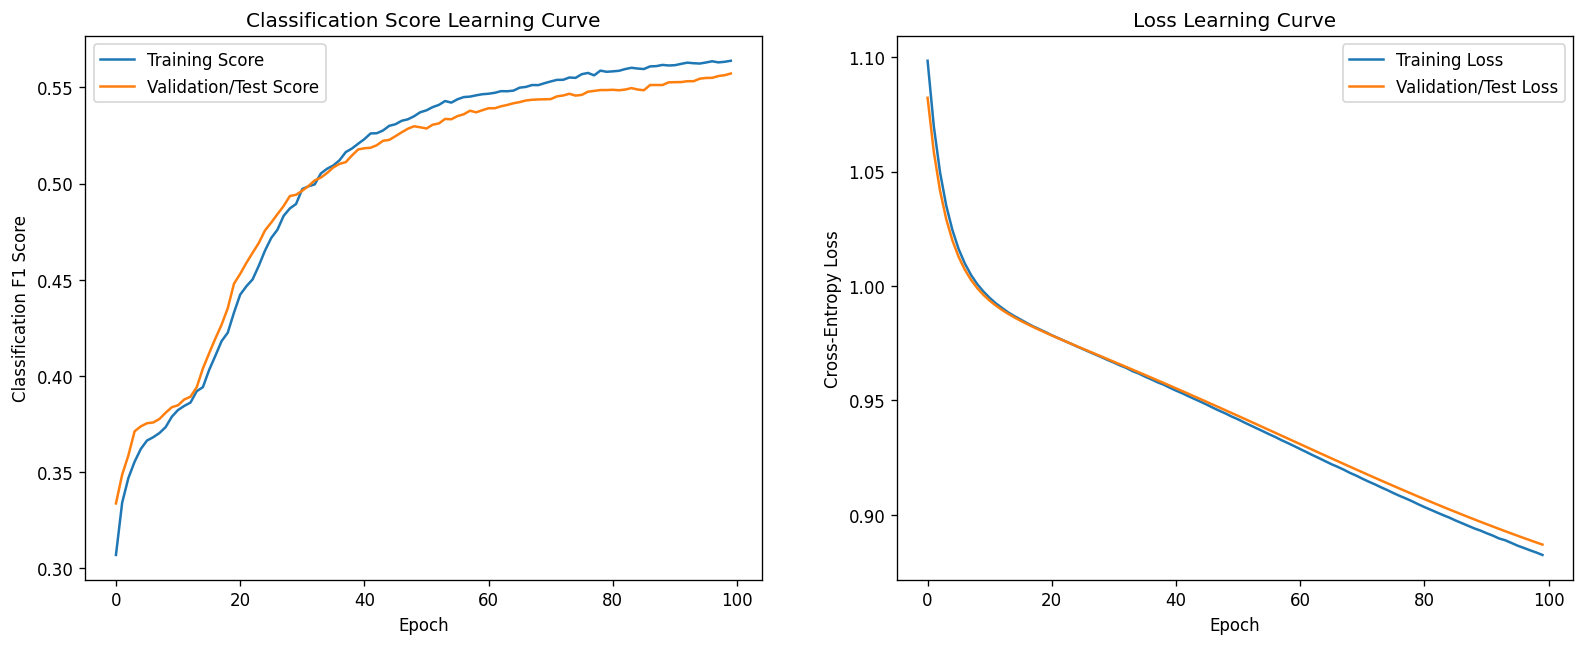

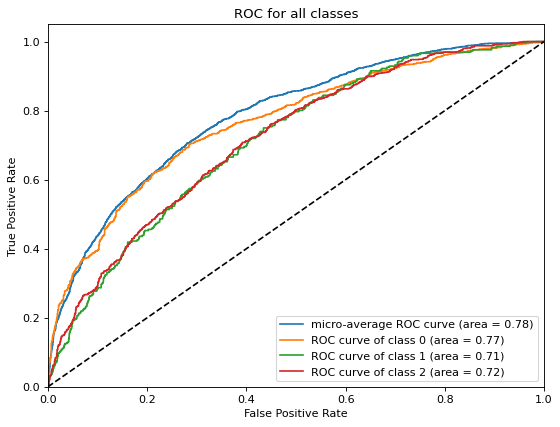

In [61]:
# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())

##Model 1: Results after Hyperparameter tuning

Classification scores for training set:

Weighted average Precision =  0.6400586574483301
Weighted average Recall    =  0.6529794692038057
Weighted average F1 score  =  0.6309715909223884



Classification scores for validation/test set:

Weighted average Precision =  0.6441372924563104
Weighted average Recall    =  0.6520595968448729
Weighted average F1 score  =  0.630366527763507







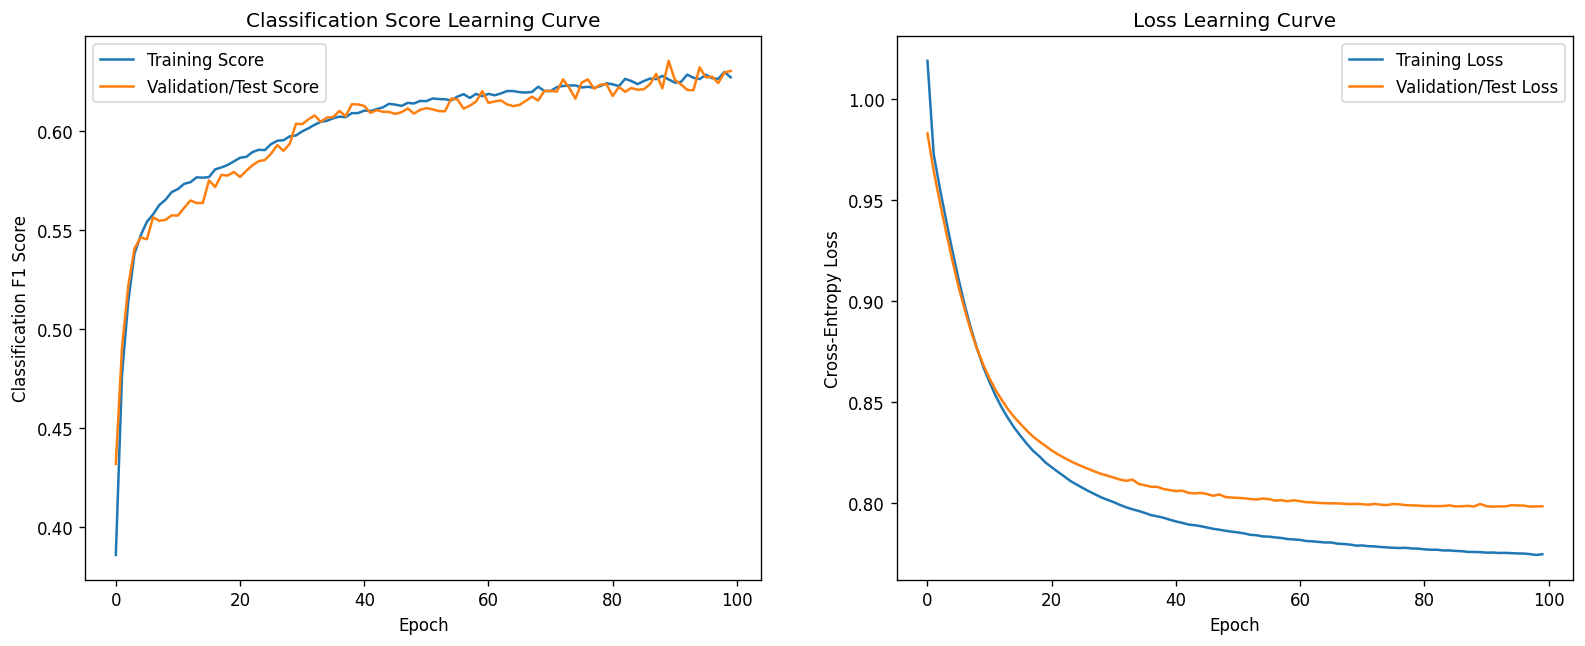

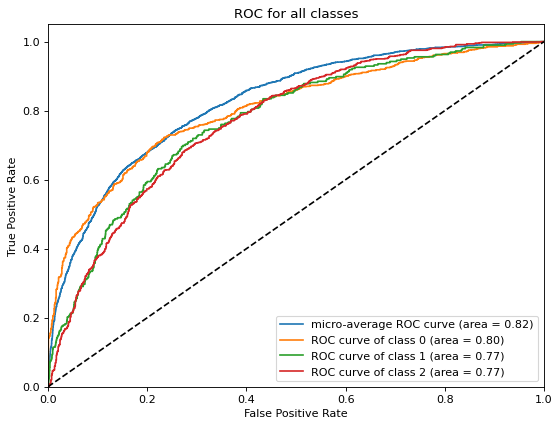

In [62]:
# HYPERMARAMETER TUNING
D_in = x_train.shape[1]
H1 = 100
D_out = 3  # we have 3 classes (pro-vax, neutral, anti-vax)

#Define learning rate
learning_rate = 1e-2

#Initialize model, loss, optimizer
model = NN_1(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# train
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 100) 

# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())

##Model 2 : neural network with two hidden layers with linear activations

In [63]:
class NN_2(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(NN_2, self).__init__()
        
        self.input_layer = nn.Linear(D_in, H1)
        self.hidden_layer = nn.Linear(H1, H2)
        self.output_layer = nn.Linear(H2, D_out)
        
    def forward(self, x):
        h1 = self.input_layer(x)              
        h2 = self.hidden_layer(h1)
        out = self.output_layer(h2)
        return out

# HYPERMARAMETER TUNING

D_in = x_train.shape[1]
# Define number of neurons for each layer
H1 = 100
H2 = 50
D_out = 3  # we have 3 classes (pro-vax, neutral, anti-vax)

#Define learning rate
learning_rate = 1e-2

#Initialize model, loss, optimizer
model = NN_2(D_in, H1, H2, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##Model 2: training

In [64]:
# train model for 100 epochs
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 100) 

##Model 2: Results

Classification scores for training set:

Weighted average Precision =  0.6438394758655925
Weighted average Recall    =  0.6549824737105658
Weighted average F1 score  =  0.6332272412870602



Classification scores for validation/test set:

Weighted average Precision =  0.6417352614178191
Weighted average Recall    =  0.6481156879929886
Weighted average F1 score  =  0.6270834465808383







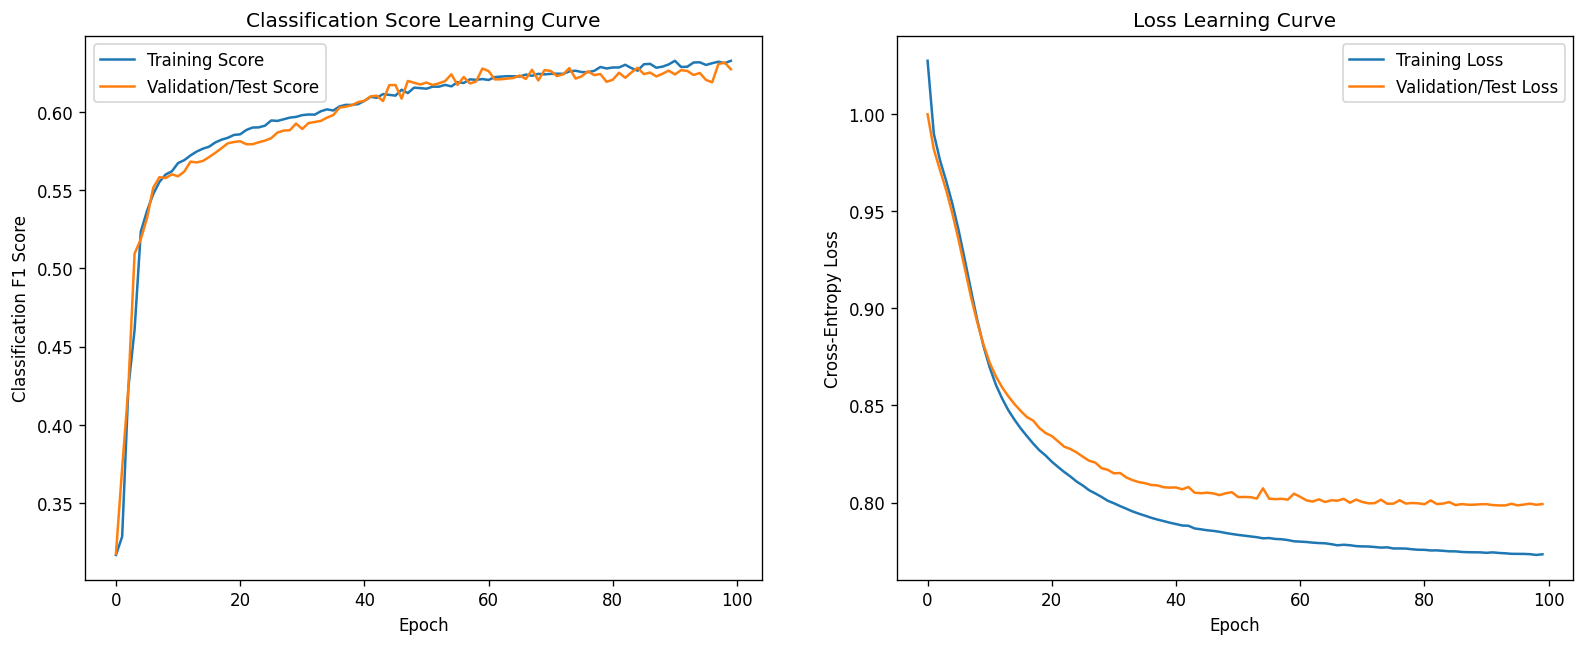

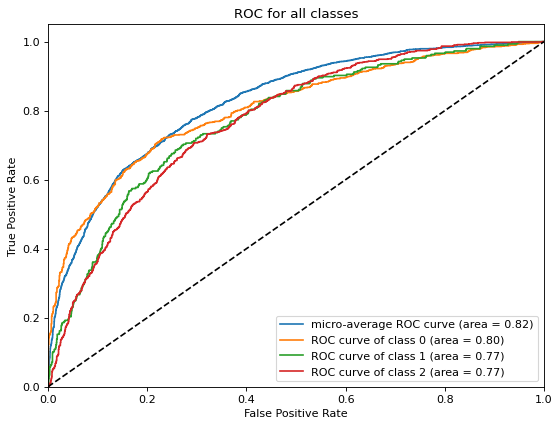

In [65]:
# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())

##Model 3 : neural network with with non-linear activations

In [66]:
class NN_3(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(NN_3, self).__init__()
        
        self.input_layer = nn.Linear(D_in, H1)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.hidden_layer1 = nn.Linear(H1, H2)
        self.hidden_layer2 = nn.Linear(H2, H3)
        self.hidden_layer3 = nn.Linear(H3, H4)
        self.output_layer = nn.Linear(H4, D_out)
        
    def forward(self, x):
        h1 = self.input_layer(x)        
        h1 = self.dropout_layer(h1)
        h2 = self.hidden_layer1(h1)
        h2 = self.relu(h2)
        h2 = self.dropout_layer(h2)            
        h3 = self.hidden_layer2(h2)
        h3 = self.relu(h3)
        h3 = self.dropout_layer(h3)
        h4 = self.hidden_layer3(h3)
        h4 = self.relu(h4)
        out = self.output_layer(h4)       
        return out

# HYPERMARAMETER TUNING

#Define layer sizes
D_in = x_train.shape[1]
# Define number of neurons for each layer
H1 = 128
H2 = 64
H3 = 32
H4 = 16
D_out = 3  # we have 3 classes (pro-vax, neutral, anti-vax)

#Define learning rate
learning_rate = 1e-1

#Initialize model, loss, optimizer
model = NN_3(D_in, H1, H2, H3, H4, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##Model 3: training

In [67]:
# train model for 100 epochs
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 100) 

##Model 3: Results

Classification scores for training set:

Weighted average Precision =  0.7170532744865117
Weighted average Recall    =  0.7093765648472709
Weighted average F1 score  =  0.7087188730250946



Classification scores for validation/test set:

Weighted average Precision =  0.694208079767807
Weighted average Recall    =  0.684487291849255
Weighted average F1 score  =  0.6843436497556229







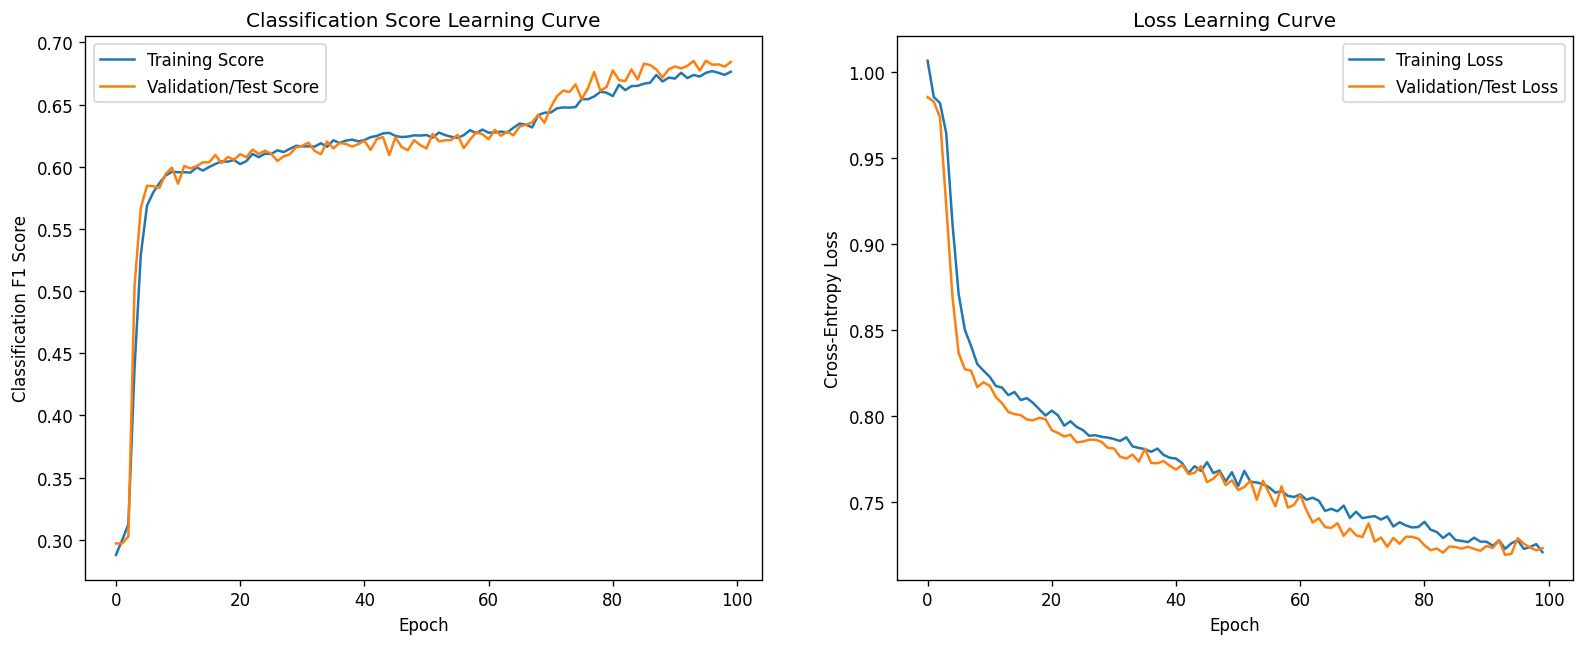

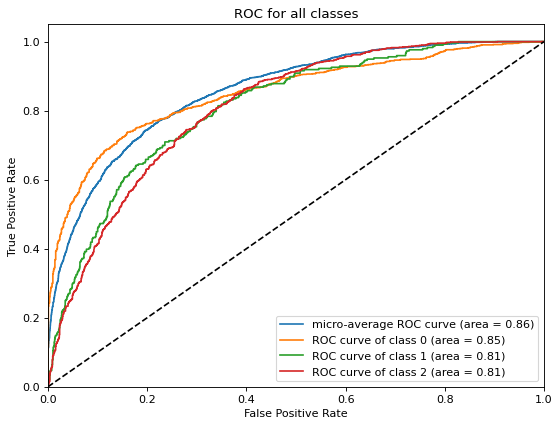

In [38]:
# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())

##Adam on model 3

Classification scores for training set:

Weighted average Precision =  0.7199782537279039
Weighted average Recall    =  0.7168252378567852
Weighted average F1 score  =  0.710547816606482



Classification scores for validation/test set:

Weighted average Precision =  0.6882832740110935
Weighted average Recall    =  0.684487291849255
Weighted average F1 score  =  0.6797384501950517







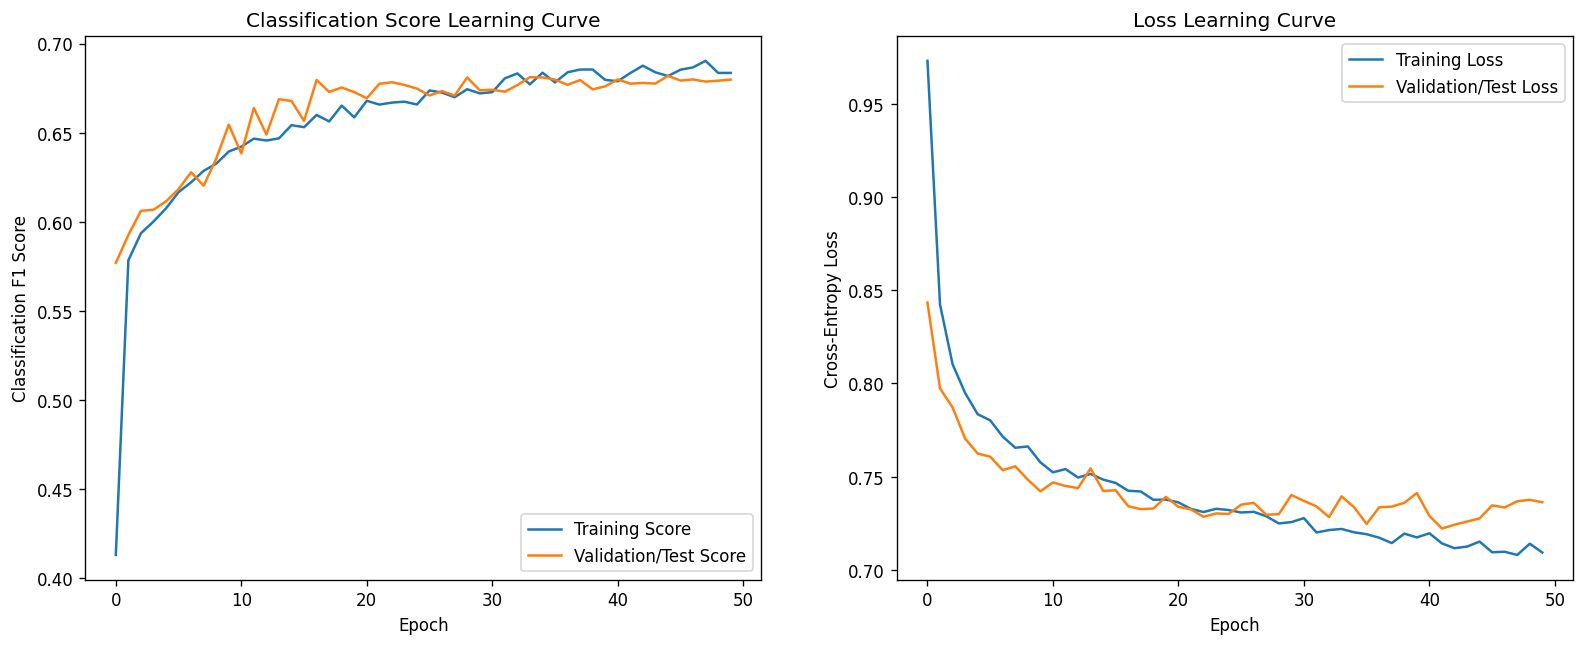

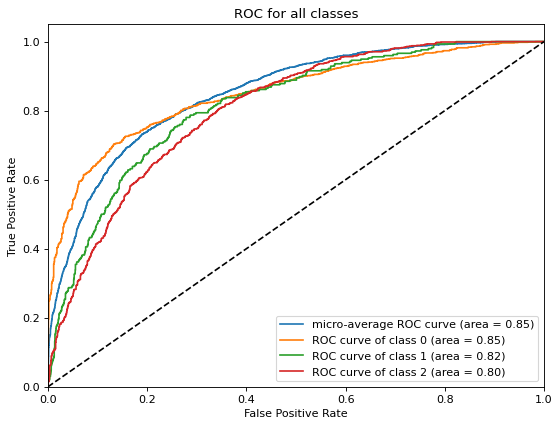

In [68]:
#Define learning rate
learning_rate = 1e-3

#Initialize model, loss, optimizer
model = NN_3(D_in, H1, H2, H3, H4, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model for 100 epochs
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 50)

# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())


##RMSprop on model 3

Classification scores for training set:

Weighted average Precision =  0.705854735019798
Weighted average Recall    =  0.7145092638958438
Weighted average F1 score  =  0.704003701408001



Classification scores for validation/test set:

Weighted average Precision =  0.664945502224372
Weighted average Recall    =  0.6752848378615249
Weighted average F1 score  =  0.6649566892555997







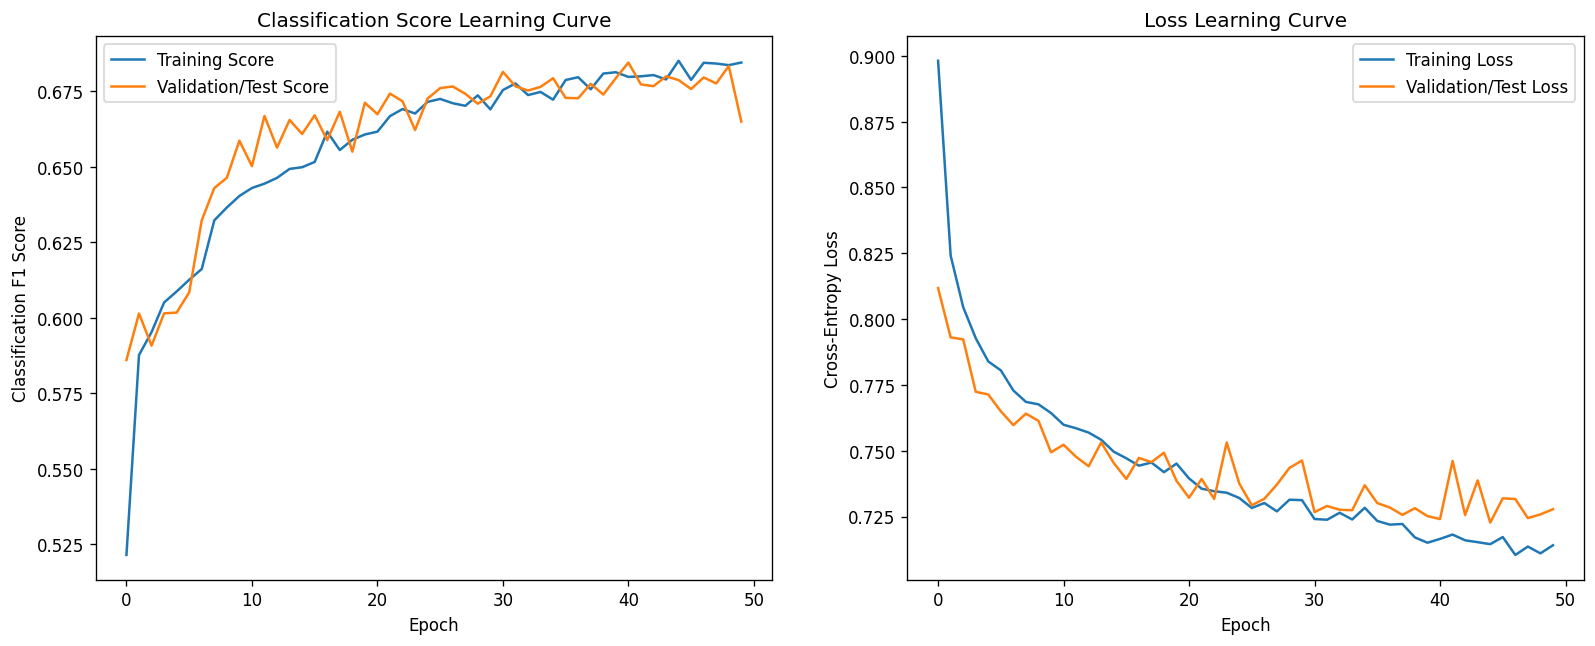

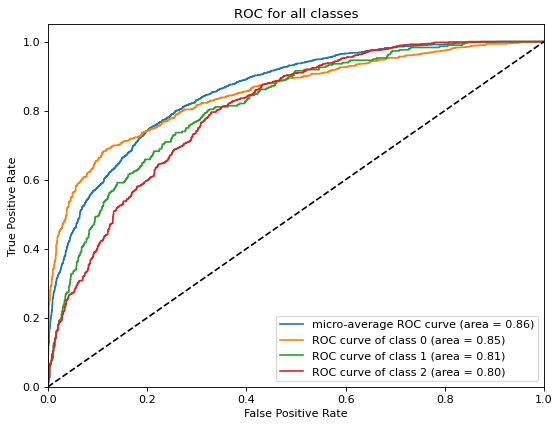

In [69]:
#Define learning rate
learning_rate = 1e-3

#Initialize model, loss, optimizer
model = NN_3(D_in, H1, H2, H3, H4, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

# train model for 100 epochs
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 50)

# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())

##Final Model

Classification scores for training set:

Weighted average Precision =  0.712346521840938
Weighted average Recall    =  0.7129444166249375
Weighted average F1 score  =  0.7084653585316816



Classification scores for validation/test set:

Weighted average Precision =  0.6838696238086195
Weighted average Recall    =  0.684487291849255
Weighted average F1 score  =  0.6800465731627631







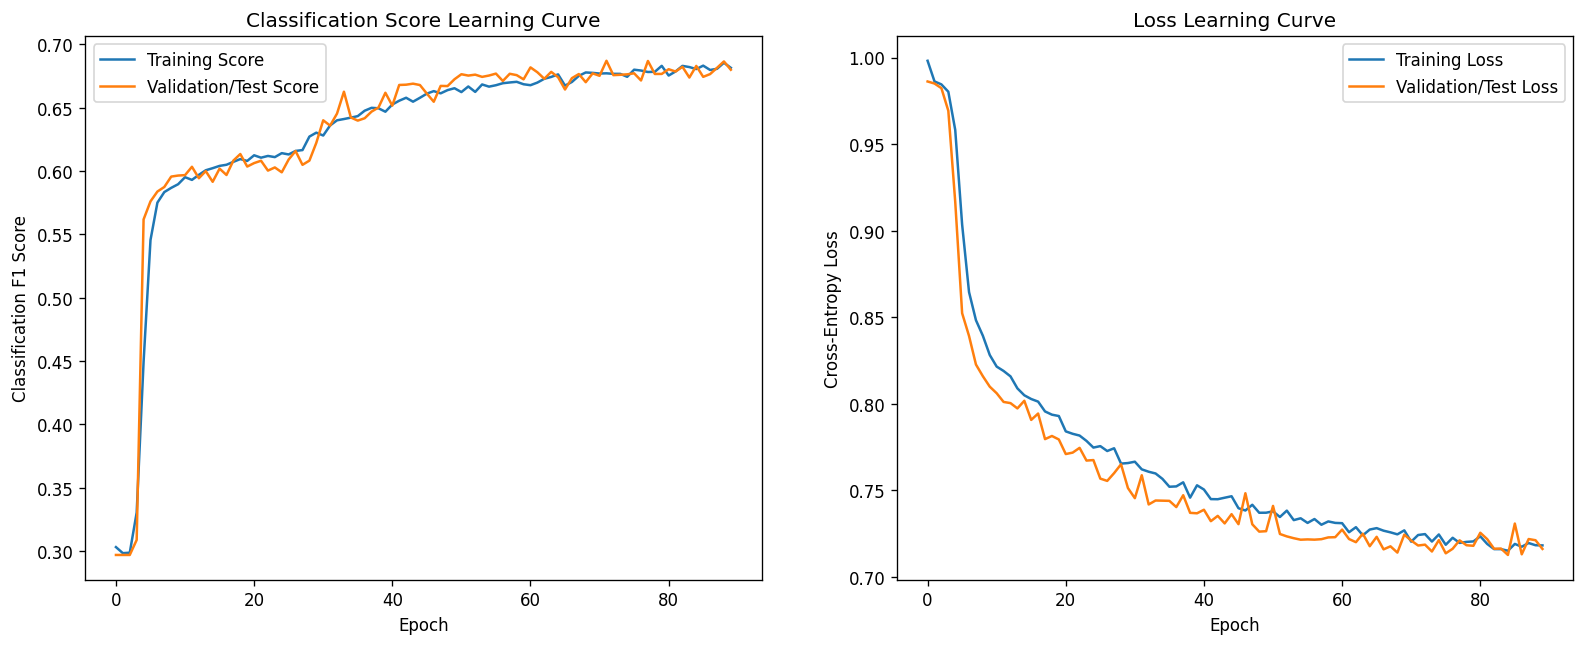

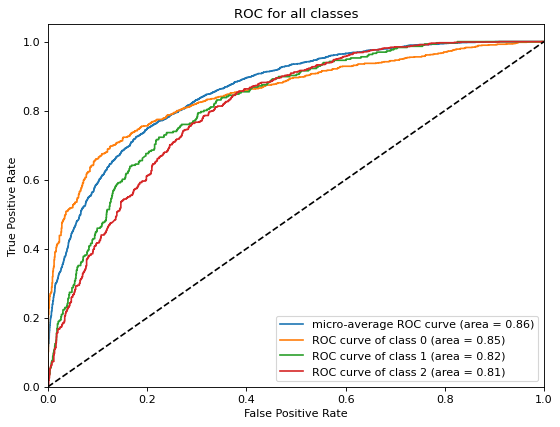

In [70]:
# MAIN FUNCTIONALITY

# dictionary with words of pre-trained corpus as keys, index of each word in embeddings array as value
word_index_dict = {}
word_index = 0
# numpy array, where each row corresponds to the vector of each word of corpus (400K words, we use 100 dimensional vector embeddings)
number_of_words = 400000
vector_size = 100
embeddings_array = np.zeros((number_of_words, vector_size))
# reading .txt file with word embeddings
with open("glove.6B.100d.txt", 'r', encoding="utf-8") as File: 
  for row in File:
    tokenized_row = row.split()          # tokenize each row of file
    word = tokenized_row[0]              # first token of row corresponds to a word of corpus
    word_vector = np.array(tokenized_row[1:]).astype(np.float)  # rest of tokenized_row is the vector corresponding to given word
    word_index_dict[word] = word_index            # save word in word_index dictionary
    embeddings_array[word_index] = word_vector    # save word vector of word in embeddings array
    word_index = word_index + 1

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")
#training_df.head()
#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")   # <------------- REPLACE TEST SET PATH HERE

cleaning = True  

if cleaning:
  # apply text cleaning for the tweets as pre-processing for the training set
  training_df['tweet'] = training_df['tweet'].apply(data_cleaning)
  # apply text cleaning for the tweets as pre-processing for the validation set
  validation_df['tweet'] = validation_df['tweet'].apply(data_cleaning)

#Seperate tweet and label columns into seperate dataframes for the training set
train_tweet_df = pd.DataFrame(training_df, columns=[training_df.columns[1]])
train_label_df = pd.DataFrame(training_df, columns=[training_df.columns[-1]])
#Seperate tweet and label columns into seperate dataframes for the validation set
val_tweet_df = pd.DataFrame(validation_df, columns=[training_df.columns[1]])
val_label_df = pd.DataFrame(validation_df, columns=[training_df.columns[-1]])

train_sentences = [x for x in train_tweet_df['tweet']]
val_sentences = [x for x in val_tweet_df['tweet']]

#Save in tensors
# for training set
x_train = sentences_to_tensor(train_sentences,vector_size, word_index_dict, embeddings_array)
y_train = torch.tensor(train_label_df.values, dtype=torch.long)
y_train = y_train.view(-1)
# for validation set
x_val = sentences_to_tensor(val_sentences, vector_size, word_index_dict, embeddings_array)
y_val = torch.tensor(val_label_df.values, dtype=torch.long)
y_val = y_val.view(-1)


class NN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(NN, self).__init__()
        
        self.input_layer = nn.Linear(D_in, H1)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.hidden_layer1 = nn.Linear(H1, H2)
        self.hidden_layer2 = nn.Linear(H2, H3)
        self.hidden_layer3 = nn.Linear(H3, H4)
        self.output_layer = nn.Linear(H4, D_out)
        
    def forward(self, x):
        h1 = self.input_layer(x)        
        h1 = self.dropout_layer(h1)
        h2 = self.hidden_layer1(h1)
        h2 = self.relu(h2)
        h2 = self.dropout_layer(h2)            
        h3 = self.hidden_layer2(h2)
        h3 = self.relu(h3)
        h3 = self.dropout_layer(h3)
        h4 = self.hidden_layer3(h3)
        h4 = self.relu(h4)
        out = self.output_layer(h4)
        return out 

# HYPERMARAMETER TUNING

#Define layer sizes
D_in = x_train.shape[1]
H1 = 128
H2 = 64
H3 = 32
H4 = 16
D_out = 3  # we have 3 classes (pro-vax, neutral, anti-vax)

#Define learning rate
learning_rate = 1e-1

#Initialize model, loss, optimizer
model = NN(D_in, H1, H2, H3, H4, D_out)
#loss_func = nn.CrossEntropyLoss(weight=class_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# train model
training_losses, validation_losses, training_scores, validation_scores, epochs, model = execute_training(model, loss_func, optimizer, 128, 90)


# Print f1, precision, recall score for final model on train/test/validation set
model.eval()
y_train_pred = model(x_train.float())
probs = F.softmax(y_train_pred, dim=1)
y_train_label_pred = probs.argmax(dim=1)
print_scores(y_train, y_train_label_pred, True)
y_val_pred = model(x_val.float())
y_probs = F.softmax(y_val_pred, dim=1)
y_val_label_pred = y_probs.argmax(dim=1)
print_scores(y_val, y_val_label_pred, False)

# Print Learning Curve
make_subplot(epochs, training_scores, validation_scores, "Classification Score Learning Curve", training_losses, validation_losses, "Loss Learning Curve")

# Print Roc Curve
plot_roc_curve(y_val, y_probs.detach().numpy())